# Лабораторная работа по дообучению моделей


## Цель и задачи работы
**Цель:**
Выявить наиболее эффективный подход к дообучению модели на нескольких наборах данных при равных вычислительных ресурсах.

**Основные задачи:**
1. Провести эксперименты с различными подходами к дообучению, включая:
   - Полное дообучение модели.
   - Заморозку части слоев и дообучение остальных.
   - Использование смешанной точности вычислений (fp16).
2. Измерить эффективность каждого подхода на основе метрик качества и времени обучения.
3. Сравнить соотношение метрики качества и скорости для каждого подхода.

**Метрики качества:**
- **Accuracy** (Точность классификации): насколько правильно модель классифицирует данные.
- **F1-score**: гармоническое среднее между полнотой (recall) и точностью (precision).

**Метрики времени:**
- Общее время обучения.
- Скорость достижения минимального лосса (число эпох или секунд).

**Формат отображения:**
Результаты будут представлены в таблицах и графиках:
- Таблицы с метриками качества и временем обучения для каждого подхода.
- Графики, показывающие изменение лосса и метрик качества на каждой эпохе.
- Отдельный график эффективности (соотношение качества и скорости).

**Ожидаемые результаты:**
- Понимание, какой подход обеспечивает лучший баланс между качеством и скоростью.
- Рекомендации для выбора стратегии дообучения в зависимости от доступных ресурсов.

## Экспериментальная часть: Дизайн и настройка экспериментов
**Параметры эксперимента:**
1. **Подходы к дообучению:**
  Подходы к дообучению:
  - дообучение с разными числом замороженных слоев (80/50/20/0)
  - дообучение с использованием адаптера LoRA, prompt и prefix-tuning

  В рамках каждого подхода предлагается проверить влияние типа данных (fp32 vs fp16 vs int8)

2. **Данные для обучения:**
   - Наборы данных с разными характеристиками (размер, сложность).
   - Пример: GLUE Benchmark для классификации текста.
3. **Метрики:**
   - Accuracy и F1-score для оценки качества модели.
   - Время обучения (в секундах или эпохах).

**Почему выбраны эти параметры:**
- Полное дообучение позволяет оценить максимум возможностей модели.
- Заморозка слоев снижает затраты на обучение и помогает понять вклад разных слоев.
- Использование fp16 ускоряет обучение и снижает нагрузку на GPU.

**Как измерять метрики:**
1. Метрики качества измеряются на тестовом наборе данных.
2. Время фиксируется для каждой эпохи и всего обучения.
3. Соотношение "качество/скорость" рассчитывается как отношение метрики (например, F1-score) к времени.

**Ожидаемые результаты:**
- Таблицы с результатами для каждого подхода.
- Графики изменения метрик и времени.
- Выводы о том, какой подход наиболее эффективен.

## Уточняющее описание: Экспериментальные параметры и ожидания
**Важно:**
- Для каждого набора параметров сохраните метрики (Accuracy, F1-score) и общее время обучения.
- Постройте графики изменения лосса и времени за каждую эпоху.

**Пример конфигурации DeepSpeed:**
```json
{
    "train_batch_size": 32,
    "gradient_accumulation_steps": 1,
    "fp16": {
        "enabled": true
    },
    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu"
        }
    },
    "steps_per_print": 200
}
```


## Запуск вне ноутбука
**Условие:**
Для обеспечения гибкости и автоматизации, обучение моделей должно выполняться вне ноутбука с использованием скриптов. В ноутбуке необходимо:
1. Показать эти скрипты (например, `train.py`, `config.json`).
2. Отобразить результаты выполнения:
   - Графики лосса за эпохи.
   - Метрики качества (Accuracy, F1-score).
   - Общее время обучения.

**Что сделать:**
1. Написать обучающий скрипт (`train.py`) для запуска модели с различными параметрами.
2. Использовать JSON-файл для конфигурации параметров обучения (пример ниже).
3. Результаты сохранить в удобном формате (например, `.csv` или `.json`) для визуализации в ноутбуке.
4. Построить графики и сделать выводы в ноутбуке на основе сохраненных данных.

**Пример запуска:**
```bash
python train.py --config config.json
```
После выполнения скрипта данные и графики добавляются в ноутбук.

## Этап 1: Предварительная настройка (10%)
На данном этапе мы:
- Настраиваем окружение.
- Загружаем необходимые библиотеки и файлы.

### Ожидаемый результат:
Корректно настроенное окружение для выполнения экспериментов.

In [1]:
# !pip install transformers adapter-transformers datasets torch
# !pip install torch deepspeed
# !pip install torch==2.0.1

In [2]:
# Возможные импорты
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer
from datasets import load_dataset
# import deepspeed
# from adapter_transformers import LoRAConfig, AdapterTrainer
from adapters import LoRAConfig, AdapterTrainer
#from transformers.adapters import AdapterConfig
from dotenv import load_dotenv

load_dotenv()
HF_TOKEN = os.environ['HUGGINGFACEHUB_API_TOKEN']

import warnings
warnings.filterwarnings("ignore")

Для начала заполните параметры конфигураций


In [3]:
# torchrun --nproc_per_node=3 your_training_script.py

# Конфигурация
# Размер batch_size определяет, сколько примеров будет обработано за один шаг вперед/назад.
# Большие размеры batch_size обычно ускоряют обучение, но требуют больше памяти GPU.
# Выбирайте размер batch_size в зависимости от доступной памяти на GPU:
# - Если у вас GPU с 16 ГБ или больше видеопамяти (например, A100, V100), можно использовать batch_size 16 или 32.
# - Если у вас 8 ГБ видеопамяти или меньше (например, GTX 1080, RTX 2060), используйте batch_size 8 или 4.
# - Уменьшите batch_size, если возникает ошибка "Out of Memory" (OOM) или недостаточно памяти.
BATCH_SIZE = 16 # Настройте в зависимости от памяти вашего GPU

# LEARNING_RATE (скорость обучения) — это критически важный гиперпараметр, который управляет тем, как сильно обновляются веса модели на каждом шаге обучения.
# Обычно для дообучения предобученных моделей (например, BERT, GPT) используется более низкая скорость обучения.
# Для больших моделей и дообучения следует начать с низкой скорости обучения, например, 2e-5 или 3e-5.
# Если модель не сходится или не улучшается, попробуйте уменьшить скорость обучения.
# Если обучение слишком медленное, можно немного увеличить скорость, но обычно для fine-tuning подходит более низкая скорость.
LEARNING_RATE = 3e-5 # Обычно работает хорошо для дообучения предобученных моделей

# NUM_EPOCHS — это количество полных проходов модели через весь обучающий набор данных.
# - Если набор данных небольшой или модель быстро сходится, можно использовать меньше эпох (например, 2-3).
# - Если набор данных большой и модель переобучается, вам может понадобиться больше эпох (например, 5-10).
# - Слишком много эпох может привести к переобучению, особенно если модель начинает запоминать данные.
# - Контролируйте результат на валидации, чтобы понять, когда стоит прекратить обучение или уменьшить количество эпох.
NUM_EPOCHS = 5 # Обычно 2-5 эпох достаточно, в зависимости от размера данных и производительности модели


OUTPUT_DIR = "./model_output"

MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Напишите инициализацию модели и токенайзера
def load_model_and_tokenizer(model_name):
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        token=HF_TOKEN,
        device_map='cuda'
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        token=HF_TOKEN
    )
    return tokenizer, model

Напишите функцию для Zero-Shot классификации с использованием подбора промптов

In [4]:
def zero_shot_classification(prompt, candidate_labels, model=None, tokenizer=None): 
    classes = ', '.join(candidate_labels)
    system_prompt = f'Read the sentence and assign it to one of these classes.: {classes}. \
                      In the response, specify only the name of the class.'
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    
    # Создаем pipeline для zero-shot классификации
    zero_shot_classifier = pipeline('text-generation', model=model, tokenizer=tokenizer)

    # Запуск классификации с поданным промптом
    result = zero_shot_classifier(prompt, max_new_tokens=50, return_full_text=False)

    return result[0]['generated_text'].split('\n')[-1]

tokenizer, model = load_model_and_tokenizer(MODEL_NAME)

# Подбор промптов: в зависимости от задачи можно использовать различные формулировки
# Пример задачи: классификация по теме текста
prompt = "The quick brown fox jumped over the lazy dog."
# Пример классов для классификации
candidate_labels = ["animals", "sports", "technology", "politics"]

# Запуск zero-shot классификации
result = zero_shot_classification(prompt, candidate_labels, model, tokenizer)
print(f"Zero-shot классификация: {result}")

# Пример для другого текста и других меток
prompt = "The latest breakthrough in quantum computing promises faster processing speeds."
candidate_labels = ["quantum computing", "politics", "technology", "finance"]
result = zero_shot_classification(prompt, candidate_labels, model, tokenizer)
print(f"Zero-shot классификация для второго примера: {result}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Zero-shot классификация: animals
Zero-shot классификация для второго примера: quantum computing


In [5]:
# Очистка памяти
model = None
tokenizer = None
result = None
torch.cuda.empty_cache()

## Этап 2: Экспериментальная часть (20%)
В этом этапе мы:
- дообучение с разными числом замороженных слоев (80/50/20/0)
- дообучение с использованием адаптера LoRA, prompt и prefix-tuning

В рамках каждого подхода предлагается проверить влияние типа данных (fp32 vs fp16 vs int8)

### Что необходимо:
1. Настроить параметры в конфигурации DeepSpeed (например, batch size, fp16).
2. Убедиться, что модель обучается корректно.

### Ожидаемый результат:
Для каждого подхода должны быть получены:
- Метрики качества.
- Время обучения.

### Пример кода:
Используйте минимальный код, ориентируясь на документацию Transformers.


## Частичное дообучение с заморозкой слоев
**Идея эксперимента:**
- Замораживание части слоев модели позволяет снизить вычислительную сложность и ускорить обучение.
- Мы обучаем только 1-2 слоя, чтобы минимизировать время и ресурсы.


**Что делать:**
1. Использовать `transformers` для настройки модели с замороженными слоями.
2. Изменять конфигурацию заморозки слоев через обучающий скрипт.
3. Собрать метрики и время обучения для каждого варианта.

**Пример кода для заморозки слоев:**
```python
from transformers import AutoModel

model = AutoModel.from_pretrained('bert-base-uncased')

# Замораживаем 80% слоев
for param in model.encoder.layer[:int(0.8 * len(model.encoder.layer))].parameters():
    param.requires_grad = False

# Только последние 20% слоев обучаются
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
```

In [ ]:
!make train

PYTHONPATH=. python src/train.py config/config.yml


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/toor/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in Config has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
ClearML Task: created new task id=e14d098e39dc4f72964af1ba9f2a3684
ClearML results page: https://app.clear.ml/projects/73cf34dc1ccc4ddbb5a06ecf6486c3d8/experiments/e14d098e39dc4f72964af1ba9f2a3684/output/log
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/toor/miniconda3/lib/python3.11/site-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed mo

In [10]:
import pandas as pd

# Преобразование результатов в таблицу
data_formats = ['float32', 'bfloat16']
results_df = pd.read_csv('results.csv')
results_df

,frozen_layers,data_format,accuracy,training_time
0,80,float32,0.779482,69.868942
1,80,bfloat16,0.744966,32.552048
2,50,float32,0.811122,88.891304
3,50,bfloat16,0.777565,40.551665
4,20,float32,0.818792,112.367987
5,20,bfloat16,0.796740,48.770269
6,0,float32,0.815916,131.164300
7,0,bfloat16,0.805369,55.799508


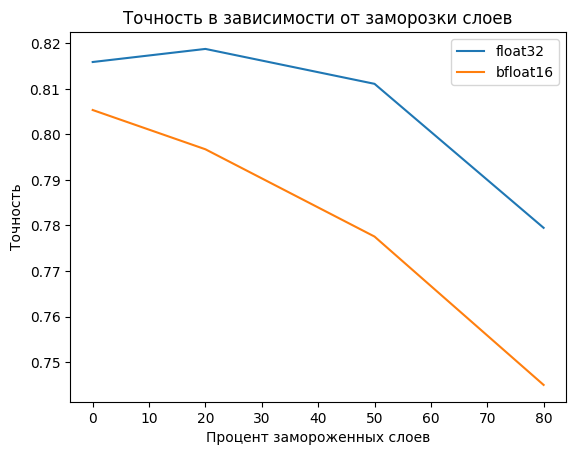

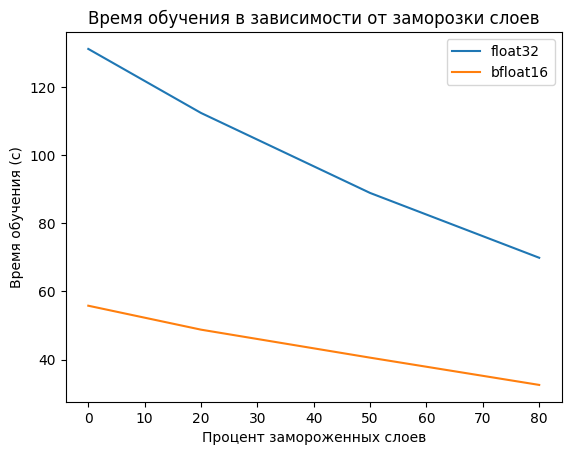

In [11]:
import matplotlib.pyplot as plt

# Построение графиков точности
for fmt in data_formats:
    subset = results_df[results_df['data_format'] == fmt]
    plt.plot(subset['frozen_layers'], subset['accuracy'], label=fmt)

plt.title('Точность в зависимости от заморозки слоев')
plt.xlabel('Процент замороженных слоев')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Построение графиков времени обучения
for fmt in data_formats:
    subset = results_df[results_df['data_format'] == fmt]
    plt.plot(subset['frozen_layers'], subset['training_time'], label=fmt)

plt.title('Время обучения в зависимости от заморозки слоев')
plt.xlabel('Процент замороженных слоев')
plt.ylabel('Время обучения (с)')
plt.legend()
plt.show()

## Этап 3: Адаптеры (30%)
## Инструкция для этапа с LoRA (Low-Rank Adaptation)

На этом этапе нужно добавить LoRA-адаптер к модели и обучить её с использованием адаптера. LoRA позволяет уменьшить количество обучаемых параметров, сохраняя при этом высокую точность модели.

## Шаги
1. **Добавление адаптера LoRA**:
   - Реализуйте функцию `add_lora_adapter`, которая добавляет адаптер LoRA к вашей модели.
   - Настройте параметры адаптера, такие как ранк (`r`) и альфа (`alpha`).
   - Убедитесь, что адаптер корректно интегрирован в модель.

2. **Настройка конфигурации адаптера**:
   - Определите конфигурацию LoRA, которая будет использоваться для добавления адаптера.
   - Используйте библиотеку `transformers` или другую совместимую с вашей моделью.

3. **Обучение модели с LoRA**:
   - Используйте `AdapterTrainer` или аналогичный инструмент для обучения модели с адаптером.
   - Настройте гиперпараметры обучения: `learning_rate`, `batch_size`, количество эпох (`epochs`) и др.

4. **Сбор и анализ метрик**:
   - Во время обучения сохраняйте метрики точности, времени обучения и использования ресурсов.
   - Сравните их с базовой моделью без адаптера.

5. **Тестирование адаптера**:
   - Проверьте работу адаптера, подав на вход модели тестовые примеры.
   - Убедитесь, что адаптер улучшает производительность на задаче.

## Пример кода для реализации
```python
def add_lora_adapter(model, r=16, alpha=32):
    from transformers.adapters import LoRAConfig
    
    # Создание конфигурации LoRA
    config = LoRAConfig(r=r, alpha=alpha)
    model.add_adapter("lora_adapter", config=config)
    model.train_adapter("lora_adapter")  # Активируем адаптер для обучения
    return model

Сделайте свой адаптер LORA, Prompt tuning и prefix tuning, после чего загрузите датасет GLUE и заполните параметры обучения и адаптера

In [ ]:
def add_lora_adapter(model, r=16, alpha=32):
    # Конфигурация адаптера LoRA
    config = # <YOUR CONFIG>
    model.add_adapter("lora_adapter", config=config)
    # <add your's adapter training>
    return model



class PromptTuning:
    def __init__(self, model, tokenizer, prompt_length=10):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_length = prompt_length
        self.prompt_tokens = # <YOUR CODE>

    def forward(self, inputs):
        # Добавление обучаемых токенов (prompt) к каждому входному примеру
        input_embeddings = # <YOUR CODE>
        prompt_embeddings =# <YOUR CODE>
        input_embeddings = # <YOUR CODE>
        return self.model(inputs['input_ids'], inputs_embeds=input_embeddings)


class PrefixTuning:
    def __init__(self, model, tokenizer, prefix_length=10):
        self.model = model
        self.tokenizer = tokenizer
        self.prefix_length = prefix_length
        self.prefix_tokens = # <YOUR CODE>

    def forward(self, inputs):
        # Добавление обучаемых префиксных токенов к каждому входному примеру
        input_embeddings = # <YOUR CODE>
        prefix_embeddings = # <YOUR CODE>
        input_embeddings = # <YOUR CODE>
        return self.model(inputs['input_ids'], inputs_embeds=input_embeddings)


def prepare_glue_dataset(tokenizer):
    glue_dataset = load_dataset("glue", "mnli")
    train_dataset = # <YOUR CODE>
    train_dataset.set_format(# <YOUR CODE>
    eval_dataset = # <YOUR CODE>
    eval_dataset.set_format(# <YOUR CODE>
    return train_dataset, eval_dataset


def train_and_evaluate(model, tokenizer, train_dataset, eval_dataset):
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        evaluation_strategy=# <YOUR CODE>,
        learning_rate=# <YOUR CODE>
        per_device_train_batch_size=# <YOUR CODE>,
        per_device_eval_batch_size=# <YOUR CODE>,
        num_train_epochs=# <YOUR CODE>,
        weight_decay=# <YOUR CODE>,
        logging_dir='./logs',
        load_best_model_at_end=True,
        fp16=True
    )

    trainer = AdapterTrainer(
        model=model,
        args=# <YOUR CODE>,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=# <YOUR CODE>
    )

    trainer.train()
    print(f"Оценка модели: {trainer.evaluate()}")


tokenizer, model = load_model_and_tokenizer(model_name)

model = add_lora_adapter(model)

train_dataset, eval_dataset = prepare_glue_dataset(tokenizer)

train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)

# Опционально, добавление Prompt Tuning и Prefix Tuning
prompt_tuning = PromptTuning(model, tokenizer)
prefix_tuning = PrefixTuning(model, tokenizer)


inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")
output = prompt_tuning.forward(inputs)
print("Результат Prompt Tuning:", output)


inputs = tokenizer("The quick brown fox jumps over the lazy dog.", return_tensors="pt")
output = prefix_tuning.forward(inputs)
print("Результат Prefix Tuning:", output)

In [ ]:
# Построение графиков точности
for adapter in adapters:
    subset = adapter_results_df[adapter_results_df['adapter'] == adapter]
    plt.bar(subset['data_format'], subset['accuracy'], label=adapter)

plt.title('Точность адаптеров по форматам данных')
plt.xlabel('Формат данных')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Построение графиков времени обучения
for adapter in adapters:
    subset = adapter_results_df[adapter_results_df['adapter'] == adapter]
    plt.bar(subset['data_format'], subset['training_time'], label=adapter)

plt.title('Время обучения адаптеров по форматам данных')
plt.xlabel('Формат данных')
plt.ylabel('Время обучения (с)')
plt.legend()
plt.show()

## Этап 4: Сравнение датасетов (20% оценки)
## Инструкция для этапа сравнения разных датасетов (CoQA, Russian SuperGLUE, SQuAD)

На этом этапе необходимо провести сравнение эффективности модели на трёх разных датасетах: CoQA, Russian SuperGLUE и SQuAD. Это поможет понять, как модель адаптируется к различным задачам и языковым доменам.

## Шаги
1. **Загрузка и предварительная обработка датасетов**:
   - Используйте библиотеку `datasets` для загрузки CoQA, Russian SuperGLUE и SQuAD.
   - Проверьте, что все датасеты имеют единообразный формат для обучения (например, вопрос-ответ).
   - Преобразуйте данные с помощью токенизатора, чтобы они соответствовали входным требованиям модели.

2. **Настройка модели для нескольких задач**:
   - Если модель поддерживает мультимодальность или многозадачное обучение, настройте её для работы с несколькими датасетами.
   - Обеспечьте поддержку языков, если используются как английский, так и русский языки (например, модель типа `mBERT`).

3. **Запуск обучения и оценки**:
   - Обучите модель отдельно на каждом датасете.
   - Для каждого датасета сохраните метрики (например, `accuracy`, `F1-score`, `EM`, время обучения).

4. **Сравнение результатов**:
   - Постройте таблицу или графики, показывающие производительность модели на каждом датасете.
   - Укажите различия в метриках, времени обучения и сложности задачи.

5. **Выводы и рекомендации**:
   - Проанализируйте, на каком датасете модель показала лучшие результаты.
   - Сделайте выводы о том, как тип данных (язык, структура вопросов и ответов) влияет на производительность.

## Пример кода
```python
from datasets import load_dataset

# Загрузка датасетов
datasets = {
    "coqa": load_dataset("coqa"),
    "russian_superglue": load_dataset("russian_superglue", "russian_superglue_diagnostic"),
    "squad": load_dataset("squad")
}

# Токенизация данных
def preprocess_data(dataset, tokenizer):
    return dataset.map(lambda x: tokenizer(x['question'], x['context'], truncation=True, padding=True), batched=True)

tokenizer = <ВАШ_ТОКЕНИЗАТОР>
preprocessed_datasets = {name: preprocess_data(ds, tokenizer) for name, ds in datasets.items()}


results = {}
for name, dataset in preprocessed_datasets.items():
    # Настройка модели и обучения
    model = <ВАША_МОДЕЛЬ>
    trainer = <НАСТРОЙТЕ_TRAINER>
    trainer.train()
    results[name] = trainer.evaluate()

# Построение графиков
import matplotlib.pyplot as plt
metrics = ["accuracy", "f1", "exact_match"]

for metric in metrics:
    values = [results[name][metric] for name in results]
    plt.bar(results.keys(), values)
    plt.title(f"Сравнение {metric} между датасетами")
    plt.xlabel("Датасеты")
    plt.ylabel(metric)
    plt.show()


In [ ]:
def prepare_russian_superglue(tokenizer):
    # Загрузка датасета Russian SuperGLUE
    russian_superglue = load_dataset("super_glue", "russian")
    # <YOUR CODE>
    return train_dataset, eval_dataset


def prepare_coqa(tokenizer):
    # Загрузка датасета CoQA
    coqa_dataset = load_dataset("coqa")
    # <YOUR CODE>
    return train_dataset, eval_dataset


def prepare_squad(tokenizer):
    # Загрузка датасета SQuAD
    squad_dataset = load_dataset("squad")
    tokenized_squad = squad_dataset.map(
        lambda examples: tokenizer(
            # <YOUR CODE>
        ),
        batched=True
    )
    tokenized_squad.set_format("torch")
    return tokenized_squad["train"], tokenized_squad["validation"]


train_dataset, eval_dataset = prepare_russian_superglue(tokenizer)
train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)


train_dataset, eval_dataset = prepare_coqa(tokenizer)
train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)


train_dataset, eval_dataset = prepare_squad(tokenizer)
train_and_evaluate(model, tokenizer, train_dataset, eval_dataset)

# Этап: Квантование и использование PEFT (Parameter-Efficient Fine-Tuning)

На этом этапе необходимо применить квантизацию модели для уменьшения её размера, а также использовать методы PEFT (например, LoRA, Prompt-Tuning, Prefix-Tuning) для дообучения модели с минимальными затратами ресурсов.

## Шаги
1. **Квантование модели**:
   - Используйте библиотеку `torch.quantization` или другие инструменты для пост-тренировочного квантования модели.
   - Проверьте, что модель корректно работает в квантованном формате (например, `int8`).
   - Измерьте влияние квантования на производительность модели и её точность.

2. **Настройка метода PEFT**:
   - Выберите один из методов PEFT (например, LoRA, Prompt-Tuning или Prefix-Tuning).
   - Настройте модель для работы с адаптерами, добавив минимальное количество параметров для дообучения.

3. **Комбинирование квантования и PEFT**:
   - После квантования добавьте адаптеры и обучите модель с использованием метода PEFT.
   - Убедитесь, что квантование не препятствует корректной работе адаптеров.

4. **Оценка и сравнение**:
   - Оцените производительность модели до и после квантования, а также после применения PEFT.
   - Сравните метрики (точность, скорость обучения, использование памяти) между вариантами.

5. **Выводы**:
   - Сделайте выводы о том, как квантование и PEFT влияют на производительность модели.
   - Определите, какой подход позволяет достичь лучшего компромисса между производительностью и использованием ресурсов.

## Пример кода
```python
import torch
from transformers import AutoModelForSequenceClassification

# Загрузка модели
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
model.eval()

# Пост-тренировочное квантование
quantized_model = torch.quantization.quantize_dynamic(
    model,  # Модель
    {torch.nn.Linear},  # Слои для квантования
    dtype=torch.qint8  # Формат квантования
)

# Проверка размера и скорости работы модели
original_size = sum(p.numel() for p in model.parameters())
quantized_size = sum(p.numel() for p in quantized_model.parameters())
print(f"Размер оригинальной модели: {original_size}, Квантованной модели: {quantized_size}")

# Добавление LoRA-адаптера после квантования
from transformers.adapters import LoRAConfig

config = LoRAConfig(r=16, alpha=32)
quantized_model.add_adapter("lora_adapter", config=config)
quantized_model.train_adapter("lora_adapter")

# Обучение модели с адаптером
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=quantized_model,
    args=training_args,
    train_dataset=<TRAIN_DATASET>,
    eval_dataset=<EVAL_DATASET>
)

trainer.train()
metrics = trainer.evaluate()
print(f"Результаты модели с LoRA после квантования: {metrics}")



In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers.adapters import LoRAConfig, AdapterTrainer, TrainingArguments
from datasets import load_dataset

# Шаг 1: Загрузка модели и токенизатора
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Переводим модель в режим инференса для квантования

# Шаг 2: Пост-тренировочное квантование
quantized_model = torch.quantization.quantize_dynamic(
    model,  # Модель
    {torch.nn.Linear},  # Слои для квантования
    dtype=torch.qint8  # Формат квантования
)

# Проверка размеров моделей
original_size = sum(p.numel() for p in model.parameters())
quantized_size = sum(p.numel() for p in quantized_model.parameters())
print(f"Размер оригинальной модели: {original_size}, квантованной модели: {quantized_size}")

# Шаг 3: Добавление LoRA-адаптера
lora_config = LoRAConfig(r=16, alpha=32)
quantized_model.add_adapter("lora_adapter", config=lora_config)
quantized_model.train_adapter("lora_adapter")

# Шаг 4: Загрузка датасета
dataset = load_dataset("glue", "sst2")
train_dataset = dataset["train"].map(
    lambda e: tokenizer(e['sentence'], truncation=True, padding="max_length"), batched=True
)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

eval_dataset = dataset["validation"].map(
    lambda e: tokenizer(e['sentence'], truncation=True, padding="max_length"), batched=True
)
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Шаг 5: Настройка аргументов обучения
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True  # Используем смешанную точность
)

# Шаг 6: Обучение модели
trainer = AdapterTrainer(
    model=quantized_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

trainer.train()

# Шаг 7: Оценка модели
metrics = trainer.evaluate()
print(f"Результаты модели с LoRA после квантования: {metrics}")


# Финальный этап: Сводная таблица результатов (10% оценки)

На этом этапе мы подводим итоги всех проведённых экспериментов. Цель — создать сводную таблицу, которая наглядно показывает производительность моделей с различными настройками (квантование, адаптеры, форматы данных и т.д.).

## Шаги

1. **Сбор всех метрик**:
   - Соберите результаты из всех этапов, включая:
     - Тип модели (оригинальная, квантованная, с адаптером).
     - Формат данных (FP32, FP16, Int8).
     - Использованный подход (LoRA, Prompt-Tuning, Prefix-Tuning).
     - Метрики точности (например, Accuracy, F1-Score, Exact Match).
     - Метрики производительности (время обучения, время инференса, использование памяти).

2. **Создание таблицы**:
   - Скомпилируйте все результаты в одну таблицу, где строки будут представлять комбинации настроек, а столбцы — метрики.
   - Пример структуры таблицы:
     ```
     +-------------------+-----------+--------+------------+--------------+-----------+----------+
     | Тип модели        | Формат    | Метод  | Accuracy   | F1-Score     | Время     | Память   |
     +-------------------+-----------+--------+------------+--------------+-----------+----------+
     | Оригинальная      | FP32      | Нет    | 92.5%      | 90.1%        | 50 сек    | 2.3 ГБ   |
     | Квантованная      | Int8      | LoRA   | 90.3%      | 88.4%        | 30 сек    | 1.2 ГБ   |
     | Квантованная+PEFT | FP16      | Prompt | 89.8%      | 87.6%        | 35 сек    | 1.5 ГБ   |
     +-------------------+-----------+--------+------------+--------------+-----------+----------+
     ```

3. **Построение графиков**:
   - Постройте графики для визуального сравнения:
     - Точность (Accuracy, F1-Score) по различным форматам данных.
     - Время обучения и инференса для каждой модели и метода.
     - Использование памяти.

4. **Выводы**:
   - На основе таблицы и графиков сделайте выводы:
     - Какой подход наиболее эффективен по соотношению производительности и ресурсов.
     - Влияние квантования и PEFT на точность и скорость работы модели.
     - Рекомендации для использования модели в реальных задачах.

## Пример кода
```python
import pandas as pd
import matplotlib.pyplot as plt

# Сводные результаты (пример данных)
data = [
    {"Тип модели": "Оригинальная", "Формат": "FP32", "Метод": "Нет", "Accuracy": 92.5, "F1-Score": 90.1, "Время (с)": 50, "Память (ГБ)": 2.3},
    {"Тип модели": "Квантованная", "Формат": "Int8", "Метод": "LoRA", "Accuracy": 90.3, "F1-Score": 88.4, "Время (с)": 30, "Память (ГБ)": 1.2},
    {"Тип модели": "Квантованная+PEFT", "Формат": "FP16", "Метод": "Prompt", "Accuracy": 89.8, "F1-Score": 87.6, "Время (с)": 35, "Память (ГБ)": 1.5},
]

# Создание DataFrame
results_df = pd.DataFrame(data)

# Печать таблицы
print("Сводная таблица результатов:")
print(results_df)

# Построение графиков
# График точности
results_df.plot(kind="bar", x="Тип модели", y=["Accuracy", "F1-Score"], figsize=(10, 5))
plt.title("Точность моделей")
plt.ylabel("Метрики (%)")
plt.xlabel("Тип модели")
plt.legend(loc="lower right")
plt.show()

# График времени
results_df.plot(kind="bar", x="Тип модели", y="Время (с)", color="orange", figsize=(10, 5))
plt.title("Время обучения и инференса")
plt.ylabel("Время (с)")
plt.xlabel("Тип модели")
plt.show()

# График памяти
results_df.plot(kind="bar", x="Тип модели", y="Память (ГБ)", color="green", figsize=(10, 5))
plt.title("Использование памяти")
plt.ylabel("Память (ГБ)")
plt.xlabel("Тип модели")
plt.show()
